## Uplift modeling experiments on CRITEO-UPLIFTv2 dataset

This code aims to:
- Show how to open and preprocess dataset
- Reproduce Table 3
- Reproduce Figure 3

In [1]:
import numpy as np
import statsmodels.api as sm
import pandas as pd
import joblib

import warnings
warnings.filterwarnings('ignore')

from sklearn import linear_model
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import normalize, OrdinalEncoder, OneHotEncoder

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold, MultilabelStratifiedShuffleSplit

import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
import seaborn as sns
%matplotlib inline

/Users/ulianavinogradova/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from tqdm.notebook import tqdm

In [3]:
from um_util import *
# from um_models import *

%load_ext autoreload
%autoreload 2

In [4]:
def get_coef_significance(X, Y):    
    X_train = sm.tools.tools.add_constant(X.values.astype(np.float64), prepend=True, has_constant='skip')
    
    Y_train = Y
#     log_reg = sm.Logit(Y_train, X_train).fit()
    lin_reg = sm.OLS(Y_train, X_train).fit()
    summary = lin_reg.summary().tables[1]
    return pd.read_html(summary.as_html(), header=0, index_col=0)[0], lin_reg

In [5]:
def check_pval(pval):
    if pval <= 0.05:
        print(f'p-val: {pval}\nСтат. значимая разница (отвергли нулевую гипотезу о равенстве средних)')
    else:
        print(f'p-val: {pval}\nСтатзначимой разницы нет')

In [6]:
def ttest(c, e):
    t_val, p = stats.ttest_ind(c, e, equal_var=False) 
    check_pval(p)
    return p

In [7]:
# ! pip install iterative-stratification

## Датасет

In [8]:
# please download data from: 
# http://go.criteo.net/criteo-research-uplift-v2.1.csv.gz

inp_df = pd.read_csv('criteo-uplift-v2.1.csv')

features = ['f{}'.format(n) for n in range(12)]
inp_df[features] = normalize(inp_df[features], axis=0, norm='l2')

X = features
y = 'visit'
t = 'treatment'

In [9]:
cat_features = ['f1', 'f3', 'f4', 'f5', 'f6', 'f8', 'f9', 'f11']
noncat_features = list(inp_df.columns.difference(cat_features + [y,t,'conversion', 'exposure']))

In [10]:
df = inp_df

In [11]:
t, p = stats.ttest_ind(df.loc[df['treatment'] == 1, 'visit'], df.loc[df['treatment'] == 0, 'visit'], equal_var=False, random_state=3)
print(f'Full data p-value: {p}')

Full data p-value: 0.0


In [12]:
df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,0.000166,0.000267,0.000284,0.000285,0.000266,0.000272,0.000013,0.000247,0.000269,0.000202,0.000266,-0.000262,1,0,0,0
1,0.000166,0.000267,0.000285,0.000285,0.000266,0.000272,0.000013,0.000247,0.000269,0.000202,0.000266,-0.000262,1,0,0,0
2,0.000166,0.000267,0.000284,0.000285,0.000266,0.000272,0.000013,0.000247,0.000269,0.000202,0.000266,-0.000262,1,0,0,0
3,0.000166,0.000267,0.000285,0.000285,0.000266,0.000272,0.000013,0.000247,0.000269,0.000202,0.000266,-0.000262,1,0,0,0
4,0.000166,0.000267,0.000286,0.000285,0.000266,0.000272,0.000013,0.000247,0.000269,0.000202,0.000266,-0.000262,1,0,0,0


## Эксперименты с уровнем значимости

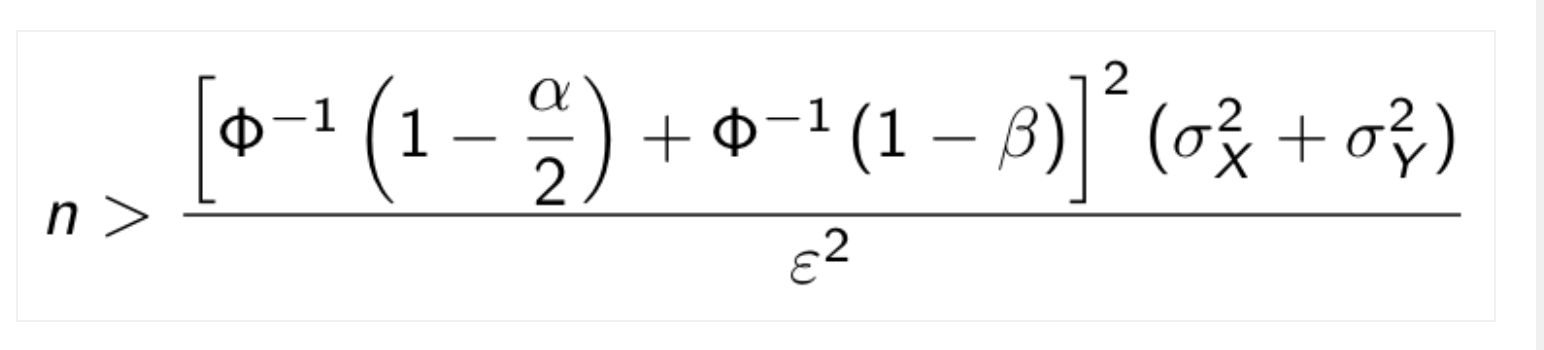

In [13]:
def get_n_samples(alpha, beta, eps, scale=1):
    f_alpha = stats.norm.ppf(1 - alpha / 2, loc=0, scale=1)
    f_beta = stats.norm.ppf(1 - beta, loc=0, scale=1)
    n_min = ((f_alpha + f_beta) ** 2 * (s_c * scale + s_t)) // (scale * eps**2)
    return n_min

In [23]:
t = df.loc[df['treatment'] == 1, 'visit'] # treatment
c = df.loc[df['treatment'] == 0, 'visit'] # control

s_t = t.var()
s_c = c.var()

p_c = c.mean()
p_t = t.mean()

In [24]:
scale = t.shape[0] / c.shape[0]
scale

5.666672389299249

In [25]:
alpha = 0.05
beta = 0.2
eps = 0.01

control_n = int(get_n_samples(alpha, beta, eps, scale=scale))
treatment_n = int(scale * control_n)
control_n, treatment_n

(3523, 19963)

In [26]:
from statsmodels.stats.power import tt_ind_solve_power 
import math

In [27]:
# tt_ind_solve_power(alpha=alpha, power=1-beta, ratio=scale, effect_size=0.01)

In [28]:
def t_tests(x, y):
    n_x = x.shape[0]
    n_y = y.shape[0]
    
    s_x = np.var(x, ddof=1)
    s_y = np.var(y, ddof=1)
    
    dof =  (s_x / n_x + s_y / n_y) ** 2 / ((s_x / n_x) ** 2 / (n_x - 1) + (s_y / n_y) ** 2 / (n_y - 1))
    
    #original t test    
    t_stat_orig = (x.mean() - y.mean()) / np.sqrt(s_x / n_x + s_y / n_y)
    p_value_orig = 2*(stats.t.cdf(-abs(t_stat_orig), dof))
    
    
    # randomized t test 
#     s_x = p_c * (1 - p_c)
#     s_y = p_t * (1 - p_t)
    
    
    theta_x = np.tile(np.array([1, np.sqrt(2), -1, -np.sqrt(2)]), n_x // 4 + 1)
    theta_x = theta_x[:n_x]
#     theta_x = theta_x / np.linalg.norm(theta_x)
    
    theta_y = np.tile(np.array([1, np.sqrt(2), -1, -np.sqrt(2)]), n_y // 4 + 1)
    theta_y = theta_y[:n_y]
#     theta_y = theta_y / np.linalg.norm(theta_y)
    
    t_stat_rand = (theta_x @ x - theta_y @ y) / np.sqrt(s_x * np.sum(theta_x ** 2) + s_y * np.sum(theta_y ** 2))
    p_value_rand = 2*(stats.t.cdf(-abs(t_stat_rand), dof))
    return (t_stat_orig, p_value_orig), (t_stat_rand, p_value_rand)

In [29]:
N_generations = 100

p_vals_standart = []
p_vals_random = []
alpha = 0.05

for i in tqdm(range(N_generations)):
    y_control = np.random.binomial(1, p_c, size=control_n)
    y_treatment = np.random.binomial(1, p_t, size=treatment_n)
    (t_stat_orig, p_value_orig), (t_stat_rand, p_value_rand) = t_tests(y_control, y_treatment)
    p_vals_standart.append(p_value_orig)
    p_vals_random.append(p_value_rand)
    
#     print(p_value_orig, p_value_rand)
#     break
first_error_orig = np.mean(np.array(p_vals_standart) >= alpha)
first_error_rand = np.mean(np.array(p_vals_random) >= alpha)

print(f"Ошибка первого рода в стандартном тесте: {first_error_orig}, в рандомном: {first_error_rand}")

100%|██████████| 100/100 [00:00<00:00, 985.02it/s]

Ошибка первого рода в стандартном тесте: 0.17, в рандомном: 0.94
